In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

# import shutup
# shutup.please()

import jax
import jax.numpy as jnp

import numpy as np
from functools import partial

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
from rich.pretty import pprint
from tqdm.auto import tqdm

from utils.datasets import GCDataset
from agents.dynamics_aware_iql import GCIQLAgent
from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['science', 'notebook'])

GLOBAL_KEY = jax.random.key(42)

,,,,

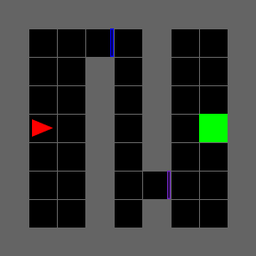
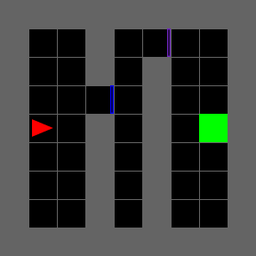
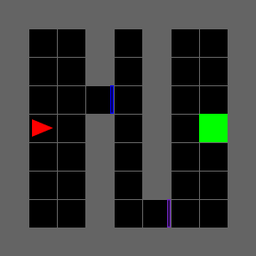
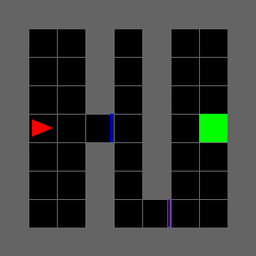
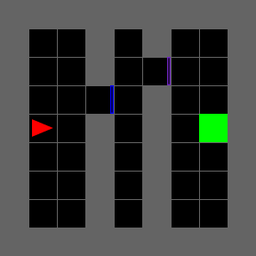

In [2]:
from envs.minigrid.doors_grid import DynamicsGeneralization_Doors, MinigridWrapper

# Train dynamics
layouts = []
for i in range(2, 7):
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=200)
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    env.reset()
    
    layouts.append(env.render())
    
mediapy.show_images(layouts, width=256, height=256)

,,,,

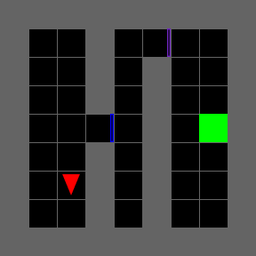
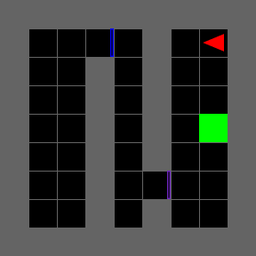
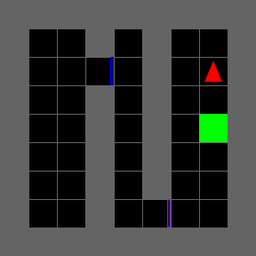
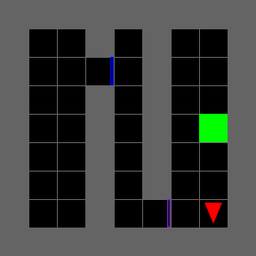
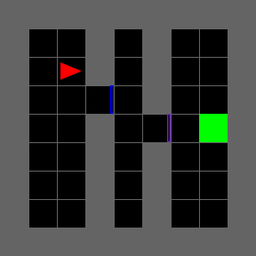

In [3]:
from envs.minigrid.doors_grid import DynamicsGeneralization_Doors, MinigridWrapper

# Test layouts
layouts = []
for i in range(14, 19):
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=200, agent_start_pos=None)
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    env.reset()
    
    layouts.append(env.render())
    
mediapy.show_images(layouts, width=256, height=256)

In [ ]:
from envs.minigrid.env_utils import random_exploration

train_layout_data = []
NUM_LAYOUTS = 2
for i in tqdm(range(NUM_LAYOUTS)):
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=512, agent_start_pos=None)
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    dataset_random, env = random_exploration(env, num_episodes=100, layout_type=i)
    train_layout_data.append(dataset_random)
    
# ds, env = random_exploration(env)
# env.visualize_coverage()

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
import functools
from utils.datasets import Dataset, GCDataset

with initialize(version_base=None, config_path="../configs/"):
    iql_config = compose(config_name='entry.yaml', overrides=['experiment=gciql_dynamics.yaml']) # gciql
    iql_config = OmegaConf.to_container(iql_config, resolve=True)
    pprint(iql_config)
    
def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = functools.reduce(concatenate_dicts, train_layout_data)
# np.save(f"../aux_data/iql_door_data_meta", arr=jax.device_get(whole_data))
# whole_data = np.load("/home/m_bobrin/ZeroShotRL/aux_data/iql_door_data_meta.npy", allow_pickle=True).item()
# whole_data = dataset_random
print(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))
gc_whole_dataset = GCDataset(whole_dataset, config=iql_config['agent'])

# batch, batch_context, batch_context2 = gc_whole_dataset.sample(1, layout_type=1, context_length=20)

{
│   'seed': 42,
│   'run_group': 'gciql',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 1000000,
│   'log_interval': 10000,
│   'eval_interval': 20000,
│   'eval_tasks': None,
│   'eval_episodes': 1,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'gciql',
│   │   'discrete': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.2,
│   │   'value_p_trajgoal': 0.5,
│   │   'value_p_randomgoal': 0.3,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 1.0,
│   │   'actor_p_randomgoal': 0.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'lr': 0.0003,
│   │   'batch_size': 16,
│   │   'const_std': True,
│   │   'actor_hidden_dims': [512, 512, 512],
│   │   'value_hidden_dims': [512, 512, 512],
│   │   'layer_norm': True,
│   │   'actor_loss': 'awr',
│   │   'alpha': 0.003,
│   │   'use_context': True,
│   │   'warmup_steps': 50000,
│   │   'n_blocks': 2,
│   │   'n_heads': 5,
│   │   'h_dim': 150,
│   │   'context_len': 256,
│   │   'number_of_meta_envs': 5,
│   │   'use_masked_attention': False,
│   │   'use_mean_embedding': True,
│   │   'cosine_schedule': False,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'expectile': 0.9
│   },
│   'env': {'env_name': 'doors_context', 'discrete': True},
│   'tags': ['dynamics_gciql', 'discrete']
}

{'actions': (51000,), 'layout_type': (51000,), 'next_observations': (51000, 2), 'observations': (51000, 2), 'terminals': (51000,)}


In [6]:
example_batch = gc_whole_dataset.sample(1)
pprint(jax.tree.map(lambda x: x.shape, example_batch))
iql_agent = GCIQLAgent.create(
    0,
    example_batch['observations'],
    np.full_like(example_batch['actions'], env.env.action_space.n - 1),
    config=iql_config['agent']
)
batch, batch_context, batch_context2 = gc_whole_dataset.sample(1, layout_type=0, context_length=20)

{
│   'actions': (1,),
│   'actor_goals': (1, 2),
│   'layout_type': (1,),
│   'masks': (1,),
│   'next_observations': (1, 2),
│   'observations': (1, 2),
│   'rewards': (1,),
│   'terminals': (1,),
│   'value_goals': (1, 2)
}

In [7]:
iql_agent.update(batch, batch_context)

(GCIQLAgent(rng=Array([4165894930,  804218099], dtype=uint32), network=TrainState(step=Array(2, dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of ModuleDict(
     # attributes
     modules = {'value': GCValue(
         # attributes
         hidden_dims = [512, 512, 512]
         layer_norm = True
         ensemble = False
         gc_encoder = None
     ), 'critic': GCDiscreteCritic(
         # attributes
         hidden_dims = [512, 512, 512]
         layer_norm = True
         ensemble = True
         gc_encoder = None
         action_dim = np.int8(4)
     ), 'target_critic': GCDiscreteCritic(
         # attributes
         hidden_dims = [512, 512, 512]
         layer_norm = True
         ensemble = True
         gc_encoder = None
         action_dim = np.int8(4)
     ), 'actor': GCDiscreteActor(
         # attributes
         hidden_dims = [512, 512, 512]
         action_dim = np.int8(4)
         final_fc_init_scale = 0.01
         gc_encoder = None
         layer

In [ ]:
pbar = tqdm(range(50_000))
for update_steps in pbar:
    # batch = gc_whole_dataset.sample(iql_config['agent']['batch_size'])#2 + update_steps % 5
    batch, batch_context, _ = gc_whole_dataset.sample(32, layout_type=update_steps % 2, context_length=iql_config['agent']['context_len'])
    iql_agent, info = iql_agent.update(batch, batch_context=batch_context)
    if update_steps % 1_000 == 0:
        pbar.set_postfix({"critic_loss": info['critic/critic_loss'],
                          "value_loss": info['value/value_loss'],
                          "actor_loss": info['actor/actor_loss']})

  0%|          | 0/50000 [00:00<?, ?it/s]

{'actions': (255,), 'layout_type': (255,), 'next_observations': (255, 2), 'observations': (255, 2), 'terminals': (255,)}


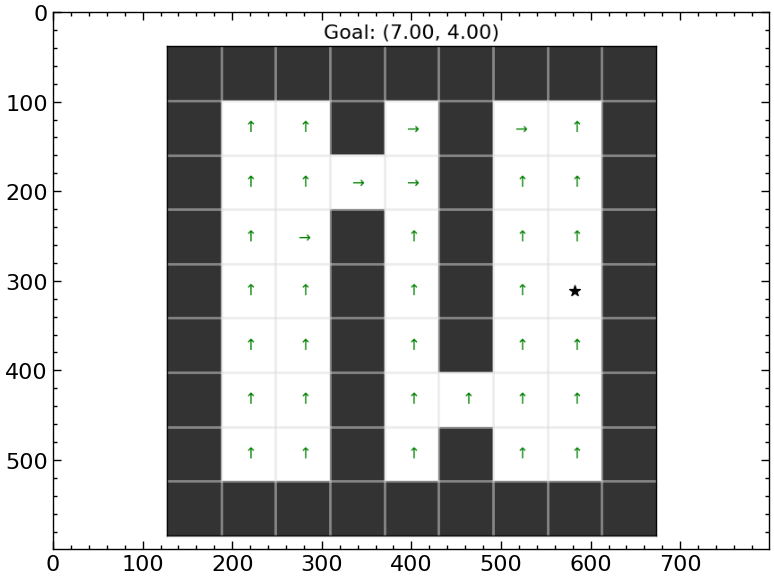

In [ ]:
from functools import partial
from utils.evaluation import supply_rng
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from envs.minigrid.env_utils import random_exploration_inference

def get_canvas_image(canvas):
    canvas.draw() 
    out_image = np.asarray(canvas.buffer_rgba())
    return out_image

def policy_image_grid(env, dataset, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_policy(env, dataset, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def plot_policy(env, dataset, fig=None, ax=None, title=None, action_fn=None, **kwargs):
    action_names = [
            r'$\leftarrow$', r'$\rightarrow$', r'$\uparrow$', r'$\downarrow$'
        ]
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)
    
    goal = kwargs.get('goal', None)
    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:
            action = action_fn(np.concatenate([[x], [y]], -1)).squeeze()
            action_name = action_names[action]
            ax.text(x, y, action_name, ha='center', va='center', fontsize='large', color='green')
            
    ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1])) 
    ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
        
    if title:
        ax.set_title(title)
        
    return fig, ax

env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=iql_config['agent']['context_len'])
env._gen_grid = partial(env._gen_grid, layout_type=1)
env = MinigridWrapper(env)
dynamics_embedding=None
if iql_config['agent']['use_context']:
    dataset_inference, env = random_exploration(env, num_episodes=1, layout_type=0)
    print(jax.tree.map(lambda x: x.shape, dataset_inference))
    dynamics_embedding, _ = iql_agent.network.select('dynamic_transformer')(dataset_inference['observations'][None], dataset_inference['actions'][None, :, None],
                                                                                dataset_inference['next_observations'][None], train=False, return_embedding=True)
    dynamics_embedding = dynamics_embedding.squeeze()

obs, info = env.reset()
goal = info.get("goal_pos", None)
example_batch = whole_dataset.sample(1)
pred_policy_img = policy_image_grid(env, example_batch,
                                                action_fn=partial(supply_rng(iql_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))),
                                                                  goals=goal, dynamics_embedding=dynamics_embedding, temperature=0.0),
                                                goal=goal)
plt.imshow(pred_policy_img)
plt.tight_layout()

{'actions': (255,), 'layout_type': (255,), 'next_observations': (255, 2), 'observations': (255, 2), 'terminals': (255,)}


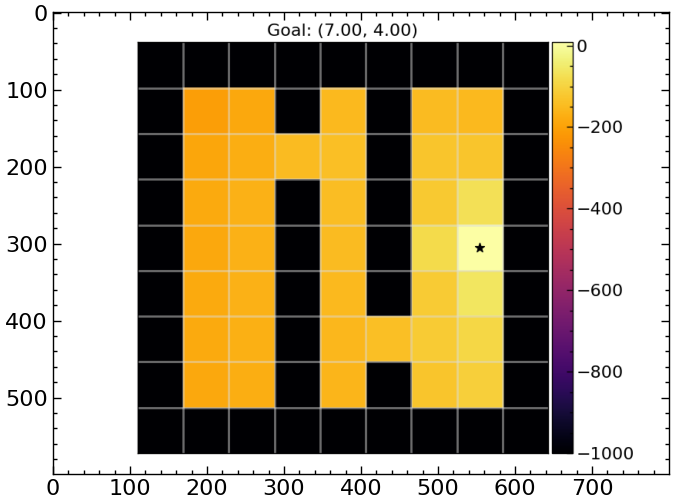

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def value_image_fourrooms(env, dataset, value_fn, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_value_image_grid(env, dataset, value_fn, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def value_fn(agent, obs, goal, action, dynamics_embedding=None):
    q1, q2 = agent.network.select('critic')(obs, goal, action, dynamics_embedding=dynamics_embedding)
    q = jnp.minimum(q1, q2)
    return q / 0.03

def plot_value_image_grid(env, dataset, value_fn, action_fn, fig=None, ax=None, title=None, **kwargs):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    goal = kwargs.get('goal', None)
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)
    # print(grid)
    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:
            action = action_fn(np.concatenate([[x], [y]], -1)).squeeze()
            grid[y, x] = jax.device_get(value_fn(np.concatenate([[x], [y]], -1), goal, action))
            
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(grid, cmap='inferno', vmin=-1000)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if goal is not None:
        ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1])) 
        ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
    return fig, ax

env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=iql_config['agent']['context_len'])
env._gen_grid = partial(env._gen_grid, layout_type=1)
env = MinigridWrapper(env)
dynamics_embedding=None
env.reset()

if iql_config['agent']['use_context']:
    dataset_inference, env = random_exploration(env, num_episodes=1, layout_type=1)
    print(jax.tree.map(lambda x: x.shape, dataset_inference))
    dynamics_embedding, _ = iql_agent.network.select('dynamic_transformer')(dataset_inference['observations'][None], dataset_inference['actions'][None, :, None],
                                                                                dataset_inference['next_observations'][None], train=False, return_embedding=True)
    dynamics_embedding = dynamics_embedding.squeeze()


pred_value_img = value_image_fourrooms(env, example_batch,
                            value_fn=partial(value_fn, iql_agent, dynamics_embedding=dynamics_embedding), action_fn=partial(supply_rng(iql_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))),
                                                                  goals=goal, temperature=0.0, dynamics_embedding=dynamics_embedding), goal=goal)
plt.imshow(pred_value_img)


In [ ]:
dynamics_embedding.mean()

Array(-0.01108214, dtype=float32)